# Open Software, Hardware & Knowledge for Space 

## Juan Luis Cano @astrojuanlu // SpaceUpBCN, 2016-11-26

![Rocket](Soyuz-Rocket-Launch.jpg)

# Space is hard. How do we _reduce_ failure?

![Crash](crash.jpg)

# My take:

# Share _everything_!

# Who is this guy??

![Me](yo.jpg)

# Let me tell you about the Free Software revolution

0. The freedom to run the program as you wish, for any purpose
1. The freedom to study how the program works and change it
2. The freedom to redistribute copies so you can help your neighbor
3. The freedom to distribute copies of your modified versions to others

## This popular Astrodynamics manual has accompaining software...

![Vallado](vallado.jpg)

## ...which doesn't always work as expected!

![response](response.jpg)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.plotting import plot
from poliastro.bodies import Sun, Earth
from poliastro.twobody import State
from poliastro import ephem

from jplephem.spk import SPK
ephem.download_kernel("de421")

File de421.bsp already exists under /home/jlcano/.poliastro


In [2]:
def go_to_mars(offset=100., tof_=6000.):
    # Initial data
    N = 50

    date_launch = time.Time('2011-11-26 15:02', scale='utc')
    date_arrival = time.Time('2012-08-06 05:17', scale='utc')
    tof = tof_ * u.h

    # Calculate vector of times from launch and arrival Julian days
    jd_launch = date_launch.jd + ((offset - 100.) * u.day).value
    jd_arrival = jd_launch + tof.to(u.day).value
    jd_vec = np.linspace(jd_launch, jd_arrival, num=N)

    times_vector = time.Time(jd_vec, format='jd')
    rr_earth, vv_earth = ephem.planet_ephem(ephem.EARTH, times_vector)
    rr_mars, vv_mars = ephem.planet_ephem(ephem.MARS, times_vector)
    # Compute the transfer orbit!
    r0 = rr_earth[:, 0]
    rf = rr_mars[:, -1]

    (va, vb), = iod.lambert(Sun.k, r0, rf, tof)

    ss0_trans = State.from_vectors(Sun, r0, va, date_launch)
    ssf_trans = State.from_vectors(Sun, rf, vb, date_arrival)
    # Extract whole orbit of Earth, Mars and transfer (for plotting)
    rr_trans = np.zeros_like(rr_earth)
    rr_trans[:, 0] = r0
    for ii in range(1, len(jd_vec)):
        tof = (jd_vec[ii] - jd_vec[0]) * u.day
        rr_trans[:, ii] = ss0_trans.propagate(tof).r

    # Better compute backwards
    jd_init = (date_arrival - 1 * u.year).jd
    jd_vec_rest = np.linspace(jd_init, jd_launch, num=N)

    times_rest = time.Time(jd_vec_rest, format='jd')
    rr_earth_rest, _ = ephem.planet_ephem(ephem.EARTH, times_rest)
    rr_mars_rest, _ = ephem.planet_ephem(ephem.MARS, times_rest)
    # Plot figure
    # To add arrows:
    # https://github.com/matplotlib/matplotlib/blob/master/lib/matplotlib/streamplot.py#L140
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    def plot_body(ax, r, color, size, border=False, **kwargs):
        """Plots body in axes object.

        """
        return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

    # I like color
    color_earth0 = '#3d4cd5'
    color_earthf = '#525fd5'
    color_mars0 = '#ec3941'
    color_marsf = '#ec1f28'
    color_sun = '#ffcc00'
    color_orbit = '#888888'
    color_trans = '#444444'

    # Plotting orbits is easy!
    ax.plot(*rr_earth.to(u.km).value, color=color_earth0)
    ax.plot(*rr_mars.to(u.km).value, color=color_mars0)
    ax.plot(*rr_trans.to(u.km).value, color=color_trans)

    ax.plot(*rr_earth_rest.to(u.km).value, ls='--', color=color_orbit)
    ax.plot(*rr_mars_rest.to(u.km).value, ls='--', color=color_orbit)

    # But plotting planets feels even magical!
    plot_body(ax, np.zeros(3), color_sun, 16)

    plot_body(ax, r0.to(u.km).value, color_earth0, 8)
    plot_body(ax, rr_earth[:, -1].to(u.km).value, color_earthf, 8)

    plot_body(ax, rr_mars[:, 0].to(u.km).value, color_mars0, 8)
    plot_body(ax, rf.to(u.km).value, color_marsf, 8)

    # Add some text
    ax.text(-0.75e8, -3.5e8, -1.5e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
    ax.text(r0[0].to(u.km).value * 1.4, r0[1].to(u.km).value * 0.4, r0[2].to(u.km).value * 1.25, "Earth at launch\n(26 Nov)", ha="left", va="bottom", backgroundcolor='#ffffff')
    ax.text(rf[0].to(u.km).value * 0.7, rf[1].to(u.km).value * 1.1, rf[2].to(u.km).value, "Mars at arrival\n(6 Ago)", ha="left", va="top", backgroundcolor='#ffffff')
    ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center", backgroundcolor='#ffffff')

    # Tune axes
    ax.set_xlim(-3e8, 3e8)
    ax.set_ylim(-3e8, 3e8)
    ax.set_zlim(-3e8, 3e8)

    # And finally!
    ax.view_init(30, 260)

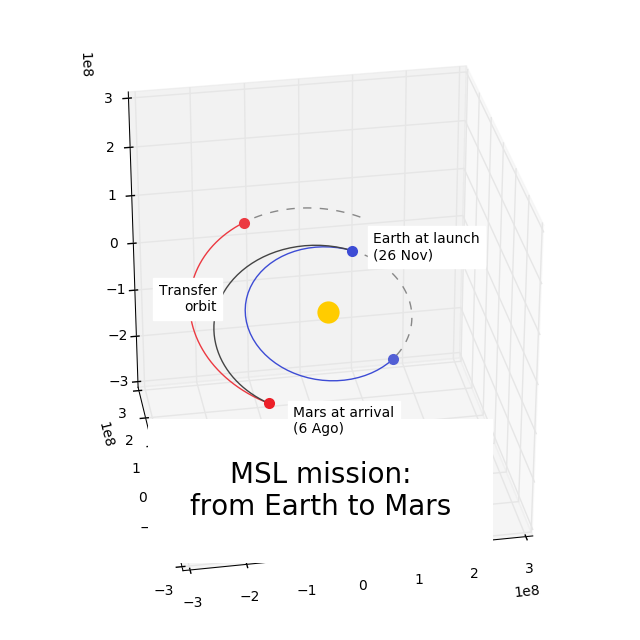

In [3]:
from IPython.html.widgets import interact

controls = interact(go_to_mars, offset=(100., 1000.), tof_=(100., 12000.))

# There's plenty of open source space software!

* Orekit - A Java Flight Dynamics framework https://www.orekit.org/
* Open Aerospace - "Modeling rockets with open source tools and methods" https://open-aerospace.github.io/
* Portland State Aerospace - Low cost, open rockets http://psas.pdx.edu/
* COSMOS - Commercial, open source control software https://github.com/BallAerospace/COSMOS

**AeroPython** - Young engineers and students learning to program for Space! https://github.com/AeroPython/

![AeroPython](pycones.jpg)

# Open Hardware: The Maker Community

![Prusa](black.jpg)

Source: http://asrob.uc3m.es/index.php/File:2012-06-25-clone-wars-genealogy.png

Author: Juan González Gómez (Obijuan)

![Genealogy](genealogy.png)

Source: http://es.slideshare.net/obijuan_cube/2016-0924minimakerfairemadrid/10

Author: Juan González Gómez (Obijuan)

![FPGA](fpga.jpg)

# Open Knowledge: The last ~~frontier~~ _frustration_

![404](404.jpg)



![paywall](paywall.png)

![Aaron](aaron.jpg)

![Standard](open.png)

# Let's do it together!

@astrojuanlu

https://www.linkedin.com/in/juanluiscanor

## ...and long live rock n' roll 🤘

![juanlu](juanlu.jpg)